Aggregated Residual Transformations for Deep Neural Networks: https://arxiv.org/pdf/1611.05431.pdf

In [13]:
from tensorflow.keras.layers import Input, Conv2D, Add, Activation, BatchNormalization, GlobalAveragePooling2D, Dense, GlobalMaxPooling2D, add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
import tensorflow as tf
import matplotlib.pyplot as plt

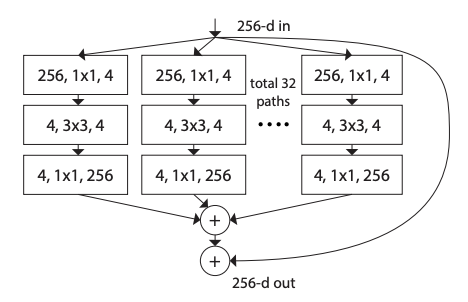

In [2]:
def resnext_block(input_tensor, filters, cardinality, kernel_size=1, groups=1, stride=1):
  #one of the other equivalent froms of the model uses grouped convoluion
  #cardinality: the size of the set of transformations
  x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same', groups=groups,
               kernel_initializer="glorot_uniform")(input_tensor)
  residual = x
  branches = []
  for i in range(cardinality):
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same', groups=groups,
               kernel_initializer="glorot_uniform")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    branches.append(x)

  x = Add()(branches) #one of the other equivalent froms of the model uses concatenation
  x = add([x, residual])

  return x

In [18]:
input_tensor = Input(shape=(32, 32, 3))
# we use 1x1 convolutions, the input is split into a few lower dimensional embeddings
x = resnext_block(input_tensor, filters = 16, kernel_size=1, cardinality=5, groups =1)
#x = resnext_block(x, filters = 16, kernel_size=3, cardinality=8, stride=2, groups =1)
#x = resnext_block(x, filters = 16, kernel_size=1, cardinality=8, groups =1)


# The original paper employs Global Average Pooling
x = GlobalAveragePooling2D()(x)

#In the original paper, the flatten layer was not utilized, so I have chosen not to use it as well. 
#However, if you would like to experiment with it, you can uncomment the relevant lines of code

#from tensorflow.keras.layers import Flatten
#Flatten()(x)

num_classes=10
output = Dense(num_classes, activation='softmax')(x)
model = Model(input_tensor, output)

In [19]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [20]:
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=5)
callbacks =[early_stopping_cb]

In [21]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

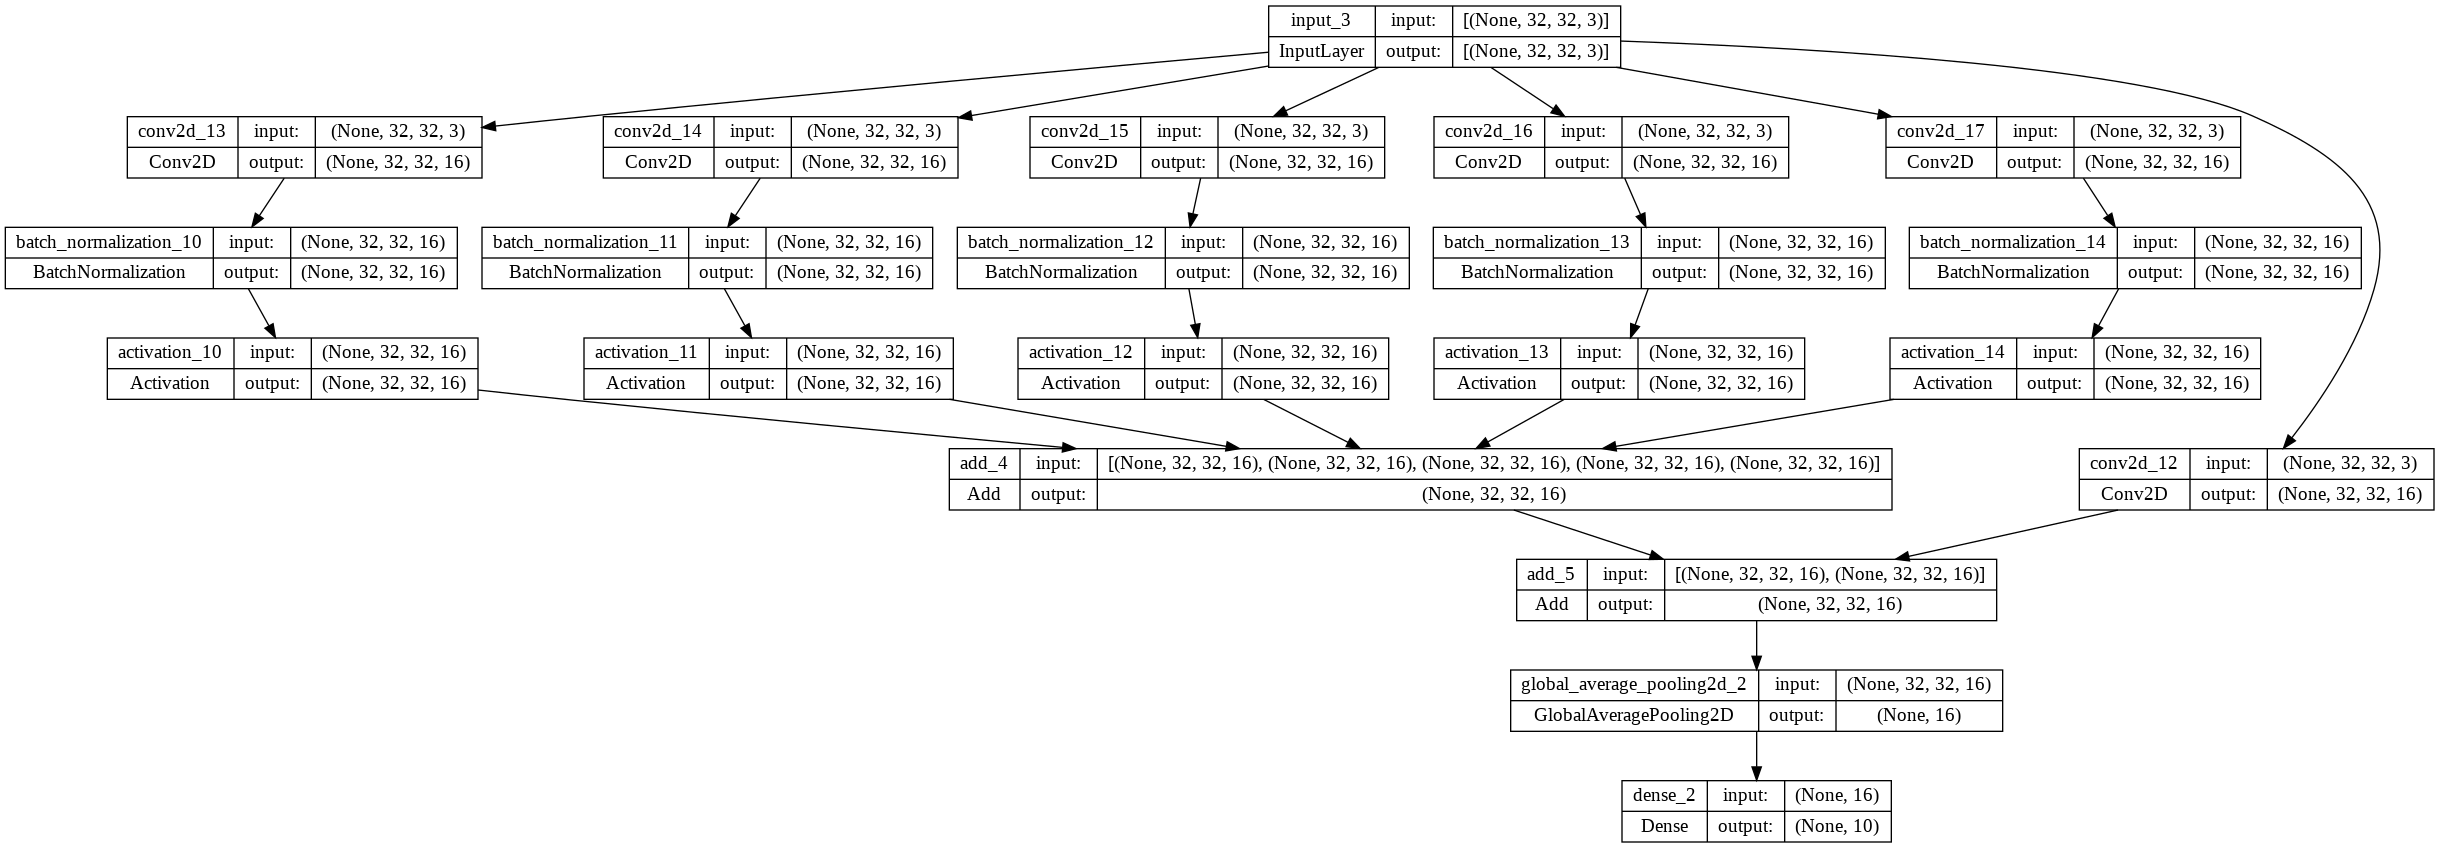

In [22]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [23]:
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.3, callbacks=callbacks)

Epoch 1/10
2188/2188 [==============================] - 14s 6ms/step - loss: 2.0593 - accuracy: 0.2335 - val_loss: 2.0418 - val_accuracy: 0.2426
Epoch 2/10
2188/2188 [==============================] - 12s 5ms/step - loss: 2.0007 - accuracy: 0.2532 - val_loss: 2.0239 - val_accuracy: 0.2315
Epoch 3/10
2188/2188 [==============================] - 12s 6ms/step - loss: 1.9869 - accuracy: 0.2634 - val_loss: 2.0356 - val_accuracy: 0.2283
Epoch 4/10
2188/2188 [==============================] - 12s 5ms/step - loss: 1.9777 - accuracy: 0.2647 - val_loss: 2.0707 - val_accuracy: 0.2347
Epoch 5/10
2188/2188 [==============================] - 12s 6ms/step - loss: 1.9732 - accuracy: 0.2653 - val_loss: 2.0676 - val_accuracy: 0.2417
Epoch 6/10
2188/2188 [==============================] - 12s 5ms/step - loss: 1.9692 - accuracy: 0.2666 - val_loss: 1.9780 - val_accuracy: 0.2697
Epoch 7/10
2188/2188 [==============================] - 12s 5ms/step - loss: 1.9664 - accuracy: 0.2690 - val_loss: 2.0220 - val_ac

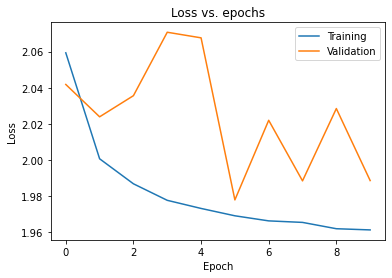

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

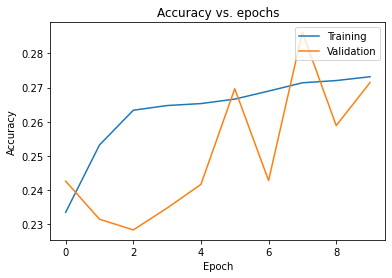

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()